In [1]:
import os

import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import random
import cv2

In [10]:
addr = {
    "REFUGE": {
        "normal": "../datasets/REFUGE/normal/images/",
        "glaucoma": "../datasets/REFUGE/glaucoma/images/",
    }
}


imgs = {"normal": [], "glaucoma": []}
for dataset in addr:
    for label in addr[dataset]:
        for img in os.listdir(addr[dataset][label]):
            if not img.startswith("."):
                # img = cv2.imread(addr[dataset][label] + img, cv2.IMREAD_GRAYSCALE)
                img = Image.open(addr[dataset][label] + img)
                img_shape = np.array(img).shape
                # crop 20%
                # img = img.crop((img_shape[0], img_shape[1], img_shape[0], img_shape[1]))
                imgs[label].append(img)
                


In [11]:
print("Number of normal images:", len(imgs["normal"]))
print("Number of glaucoma images:", len(imgs["glaucoma"]))

# shape of images
print("Shape of normal images:", np.array(imgs["normal"][0]).shape)


Number of normal images: 1080
Number of glaucoma images: 120
Shape of normal images: (512, 512, 3)


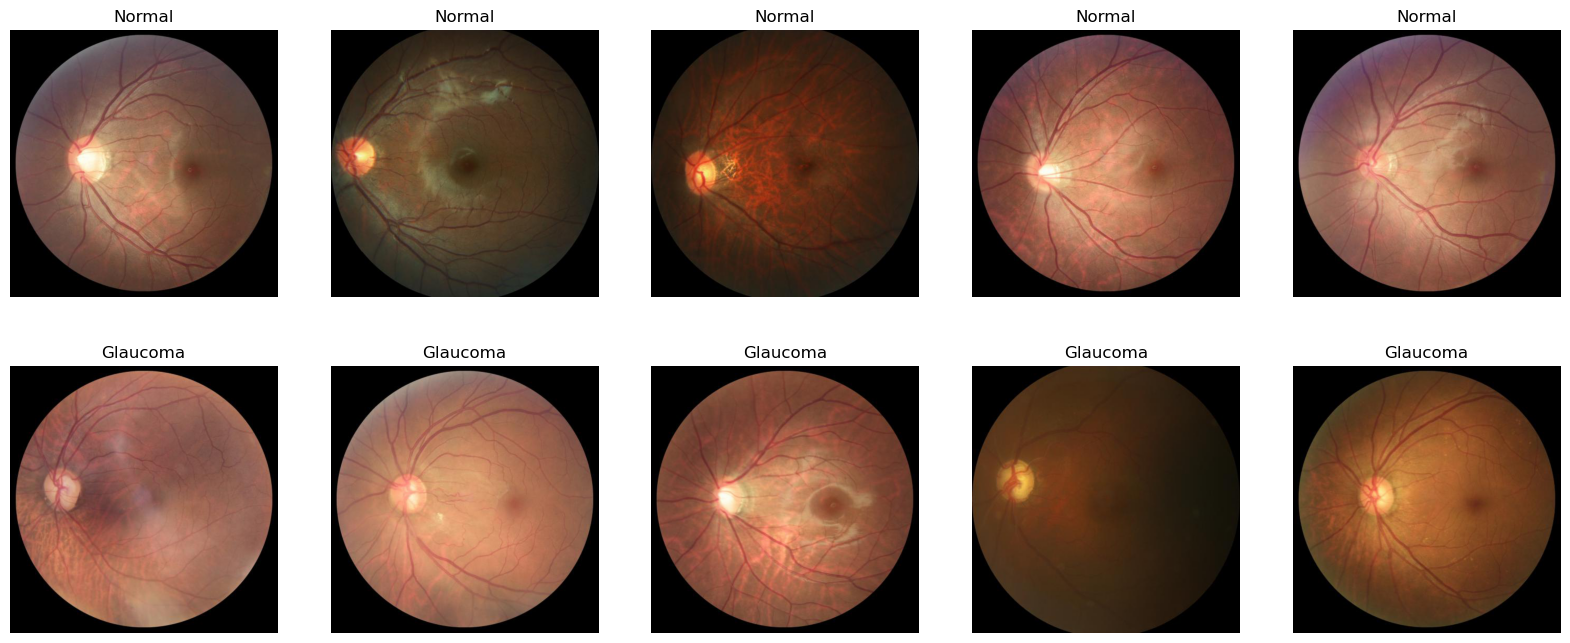

In [13]:
n = 5
# show random n normal and glaucoma images 2*n
fig, axs = plt.subplots(2, n, figsize=(4*n, 8))

# select n random normal images
for i in range(n):
    axs[0, i].imshow(imgs["normal"][random.randint(0, len(imgs["normal"]))])
    axs[0, i].axis("off")
    axs[0, i].set_title("Normal")

# select n random glaucoma images
for i in range(n):
    axs[1, i].imshow(imgs["glaucoma"][random.randint(0, len(imgs["glaucoma"]))])
    axs[1, i].axis("off")
    axs[1, i].set_title("Glaucoma")

plt.show()

In [38]:
# load attention unet model and checkpoint
import sys
# put the path of the project
sys.path.append('/home/maheshda/glaucoma_classification')
from src.models.att_unet import AttentionUNet

att_unet = AttentionUNet(in_channels=3, out_channels=2).cuda()
att_unet.load_state_dict(torch.load('/home/maheshda/glaucoma_classification/src/checkpoints/att-unet-checkpoint_25.pth.tar'))

<All keys matched successfully>

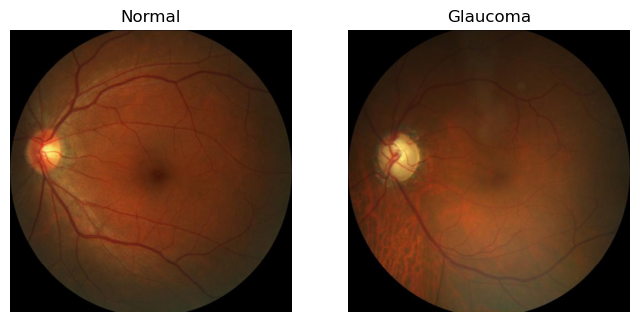

In [59]:
test_normal = imgs["normal"][random.randint(0, len(imgs["normal"]))]
test_glaucoma = imgs["glaucoma"][random.randint(0, len(imgs["glaucoma"]))]

# show test images
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].title.set_text("Normal")
axs[0].imshow(test_normal)
axs[0].axis("off")

axs[1].title.set_text("Glaucoma")
axs[1].imshow(test_glaucoma)
axs[1].axis("off")

plt.show()

Shape of normal tensor: torch.Size([1, 3, 240, 240])
Shape of glaucoma tensor: torch.Size([1, 3, 240, 240])
Shape of normal prediction: torch.Size([240, 240])
Shape of glaucoma prediction: torch.Size([1, 2, 240, 240])


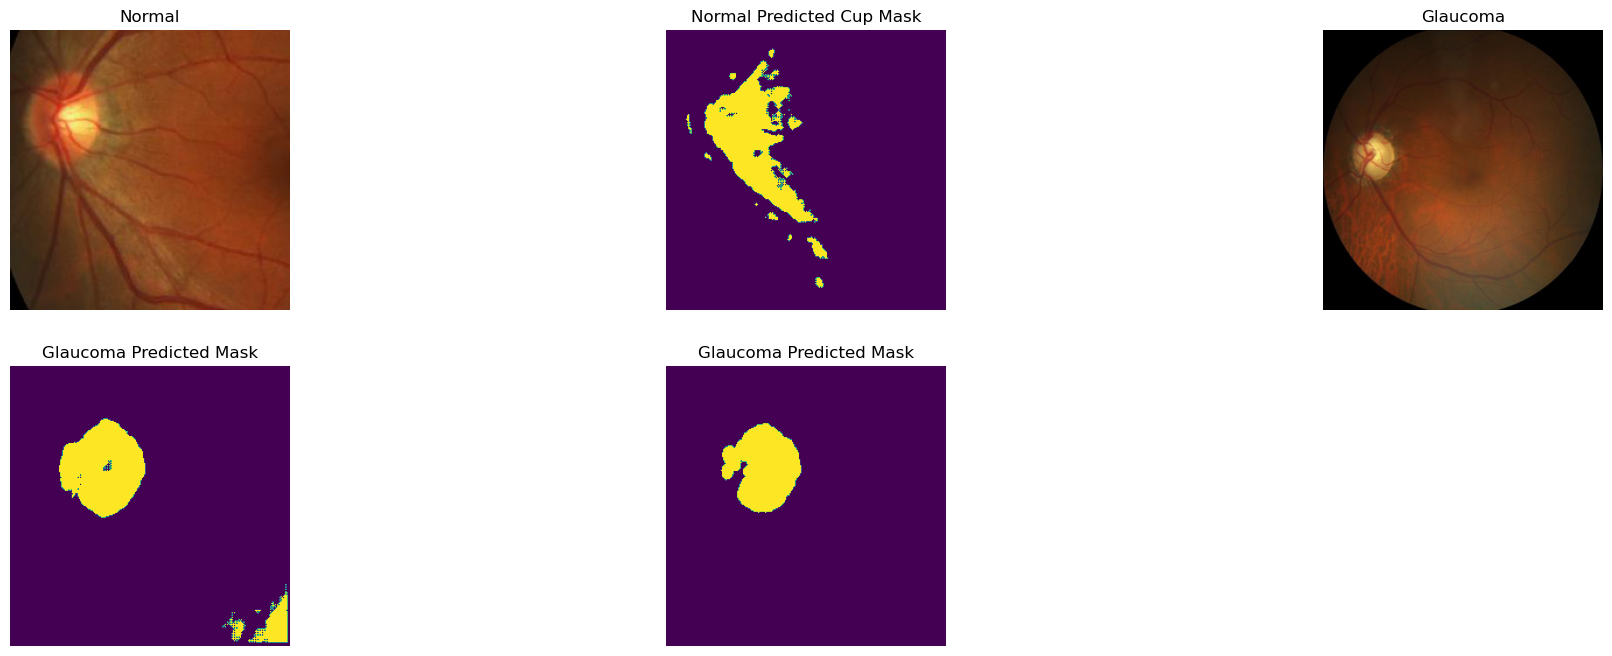

In [83]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

val_transform = A.Compose(
    [
        A.Crop(16, 144, 256, 384),
        # A.Resize(128, 128),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ],
    additional_targets={
        'mask1': 'image',
        'mask2': 'image'
    }
)

torch.cuda.set_device(0)


# apply transform
test_normal_tensor = val_transform(image=np.array(test_normal, dtype=np.float32))["image"]
test_glaucoma_tensor = val_transform(image=np.array(test_glaucoma, dtype=np.float32))["image"]


# add batch dimension
test_normal_tensor = test_normal_tensor.unsqueeze(0)
test_glaucoma_tensor = test_glaucoma_tensor.unsqueeze(0)
print(f'Shape of normal tensor: {test_normal_tensor.shape}')
print(f'Shape of glaucoma tensor: {test_glaucoma_tensor.shape}')


# # predict
# test_normal_pred = torch.sigmoid(att_unet(test_normal_tensor.float().cuda()))
# test_glaucoma_pred = torch.sigmoid(att_unet(test_glaucoma_tensor.float().cuda()))
test_normal_pred = att_unet(test_normal_tensor.float().cuda())
test_glaucoma_pred = att_unet(test_glaucoma_tensor.float().cuda())


test_normal_pred = (test_normal_pred > 0.5).float()
test_glaucoma_pred = (test_glaucoma_pred > 0.5).float()

print(f'Shape of normal prediction: {test_normal_pred[0][0].shape}')
print(f'Shape of glaucoma prediction: {test_glaucoma_pred.shape}')
# # threshold
# test_normal_cup = (test_normal_cup > 0.5).float()
# test_normal_od = (test_normal_od > 0.5).float()
# test_glaucoma_cup = (test_glaucoma_cup > 0.5).float()
# test_glaucoma_od = (test_glaucoma_od > 0.5).float()


# # show test images and predicted masks
plt.figure(figsize=(24, 8))
plt.subplot(2, 3, 1)
plt.title("Normal")
plt.imshow(test_normal_tensor[0].cpu().detach().permute(1,2,0).numpy())
plt.axis("off")
plt.subplot(2, 3, 2)
plt.title("Normal Predicted Cup Mask")
plt.imshow(test_normal_pred[0][0].cpu().detach().numpy())
plt.axis("off")
plt.subplot(2, 3, 3)
plt.title("Normal Predicted Cup Mask")
plt.imshow(test_normal_pred[0][1].cpu().detach().numpy())
plt.axis("off")
plt.subplot(2, 3, 4)
plt.title("Glaucoma")
plt.imshow(test_glaucoma)
plt.axis("off")
plt.subplot(2, 3, 5)
plt.title("Glaucoma Predicted Mask")
plt.imshow(test_glaucoma_pred[0][0].cpu().detach().numpy())
plt.axis("off")
plt.subplot(2, 3, 6)
plt.title("Glaucoma Predicted Mask")
plt.imshow(test_glaucoma_pred[0][1].cpu().detach().numpy())
plt.axis("off")
plt.show()


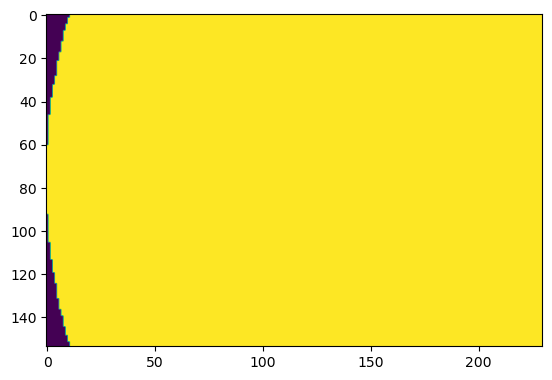

In [68]:
# thresolding
def threshold(img, mask=None):
    # # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to the image to create a binary image
    if mask is not None:
        thresh = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY)[1]
    else: 
        thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]

    return Image.fromarray(thresh)

thresholded_normal = threshold(np.array(test_normal))

plt.imshow(thresholded_normal)




In [64]:
# contours
contours_normal, _ = cv2.findContours(thresh_normal, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours_glaucoma, _ = cv2.findContours(thresh_glaucoma, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# show contours
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].title.set_text("Normal")
axs[0].imshow(cv2.drawContours(test_normal, contours_normal, -1, (0, 255, 0), 2))
axs[0].axis("off")

axs[1].title.set_text("Glaucoma")
axs[1].imshow(cv2.drawContours(test_glaucoma, contours_glaucoma, -1, (0, 255, 0), 2))
axs[1].axis("off")

plt.show()

NameError: name 'thresh_normal' is not defined

In [4]:
# segment optic disc using clustering
def segment_optic_disc(img):
    # reshape image to 1D array
    img = img.reshape((img.shape[0] * img.shape[1], 1))
    # convert to float
    img = np.float32(img)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    _, label, center = cv2.kmeans(img, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res = res.reshape((img.shape[0], img.shape[1]))
    return res

segment_optic_disc_normal = segment_optic_disc(test_normal)
segment_optic_disc_glaucoma = segment_optic_disc(test_glaucoma)

# show segmented optic disc
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].title.set_text("Normal")
axs[0].imshow(segment_optic_disc_normal.reshape(test_normal.shape))
axs[0].axis("off")
axs[1].title.set_text("Glaucoma")
axs[1].imshow(segment_optic_disc_glaucoma.reshape(test_glaucoma.shape))
axs[1].axis("off")
plt.show()

NameError: name 'test_normal' is not defined